# Read Cython OpenBCI .xdf data

In [1]:
import pyxdf
import PyQt5
import mne
import numpy as np
import pathlib
import mne
import matplotlib
import matplotlib.pyplot as plt
# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

## Set data path and read data

In [2]:
current_path = pathlib.Path().absolute()  
data_fname = current_path /'P300_test1.xdf'
print(data_fname)
streams, header = pyxdf.load_xdf(data_fname)

/Users/ordez/Documents/BCI_ALS/P300_test1.xdf


## before we are able to create a MNE raw instance, we need to create "info" object and prepare the data
(https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html#sphx-glr-auto-tutorials-simulation-10-array-objs-py)

Look for data[0:13] and data[13:], the first 13 rows should contain the actual electrode while the last 3 contains the Na channels 

In [3]:
stream_count = 0

for stream in streams:
    if stream['info']['channel_count'] == ['16']:
        eeg_stream = stream
        #data_eeg = stream["time_series"].T
        stream_count += 1
    elif stream['info']['channel_count'] == ['1']:
        marker_stream = stream
        stream_count += 1
    else:
        print('Not recognized channel')

    
print (f'{stream_count} streams loaded') 

# Prepare the time series data

eeg_data = eeg_stream["time_series"].T

2 streams loaded


In [4]:
# Create Raw without sim channel

ch_types = ['eeg'] * 13 
ch_names = ['C3','C4','Cz','FC1','FC2','FC5','FC6','CP1','CP2','CP5','CP6','O1','O2']



#data_marker = streams[0]
 
eeg_data = eeg_data[0:13]
#data[:4:2] -= data[1:4:2]  # subtract (rereference) to get two bipolar EEG
#data = data[::2]  # subselect
#data *= 1000
eeg_data *= (1e-6 / 50 / 2)  # Not sure if that is the correct way (uV -> V and preamp gain)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])
info = mne.create_info(ch_names= ch_names, ch_types=ch_types, sfreq=sfreq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: C3, C4, Cz, FC1, FC2, FC5, FC6, CP1, CP2, CP5, CP6, O1, O2
 chs: 13 EEG
 custom_ref_applied: False
 dig: 16 items (3 Cardinal, 13 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 13
 projs: []
 sfreq: 250.0 Hz
>

Creating RawArray with float64 data, n_channels=13, n_times=20430
    Range : 0 ... 20429 =      0.000 ...    81.716 secs
Ready.
Using matplotlib as 2D backend.


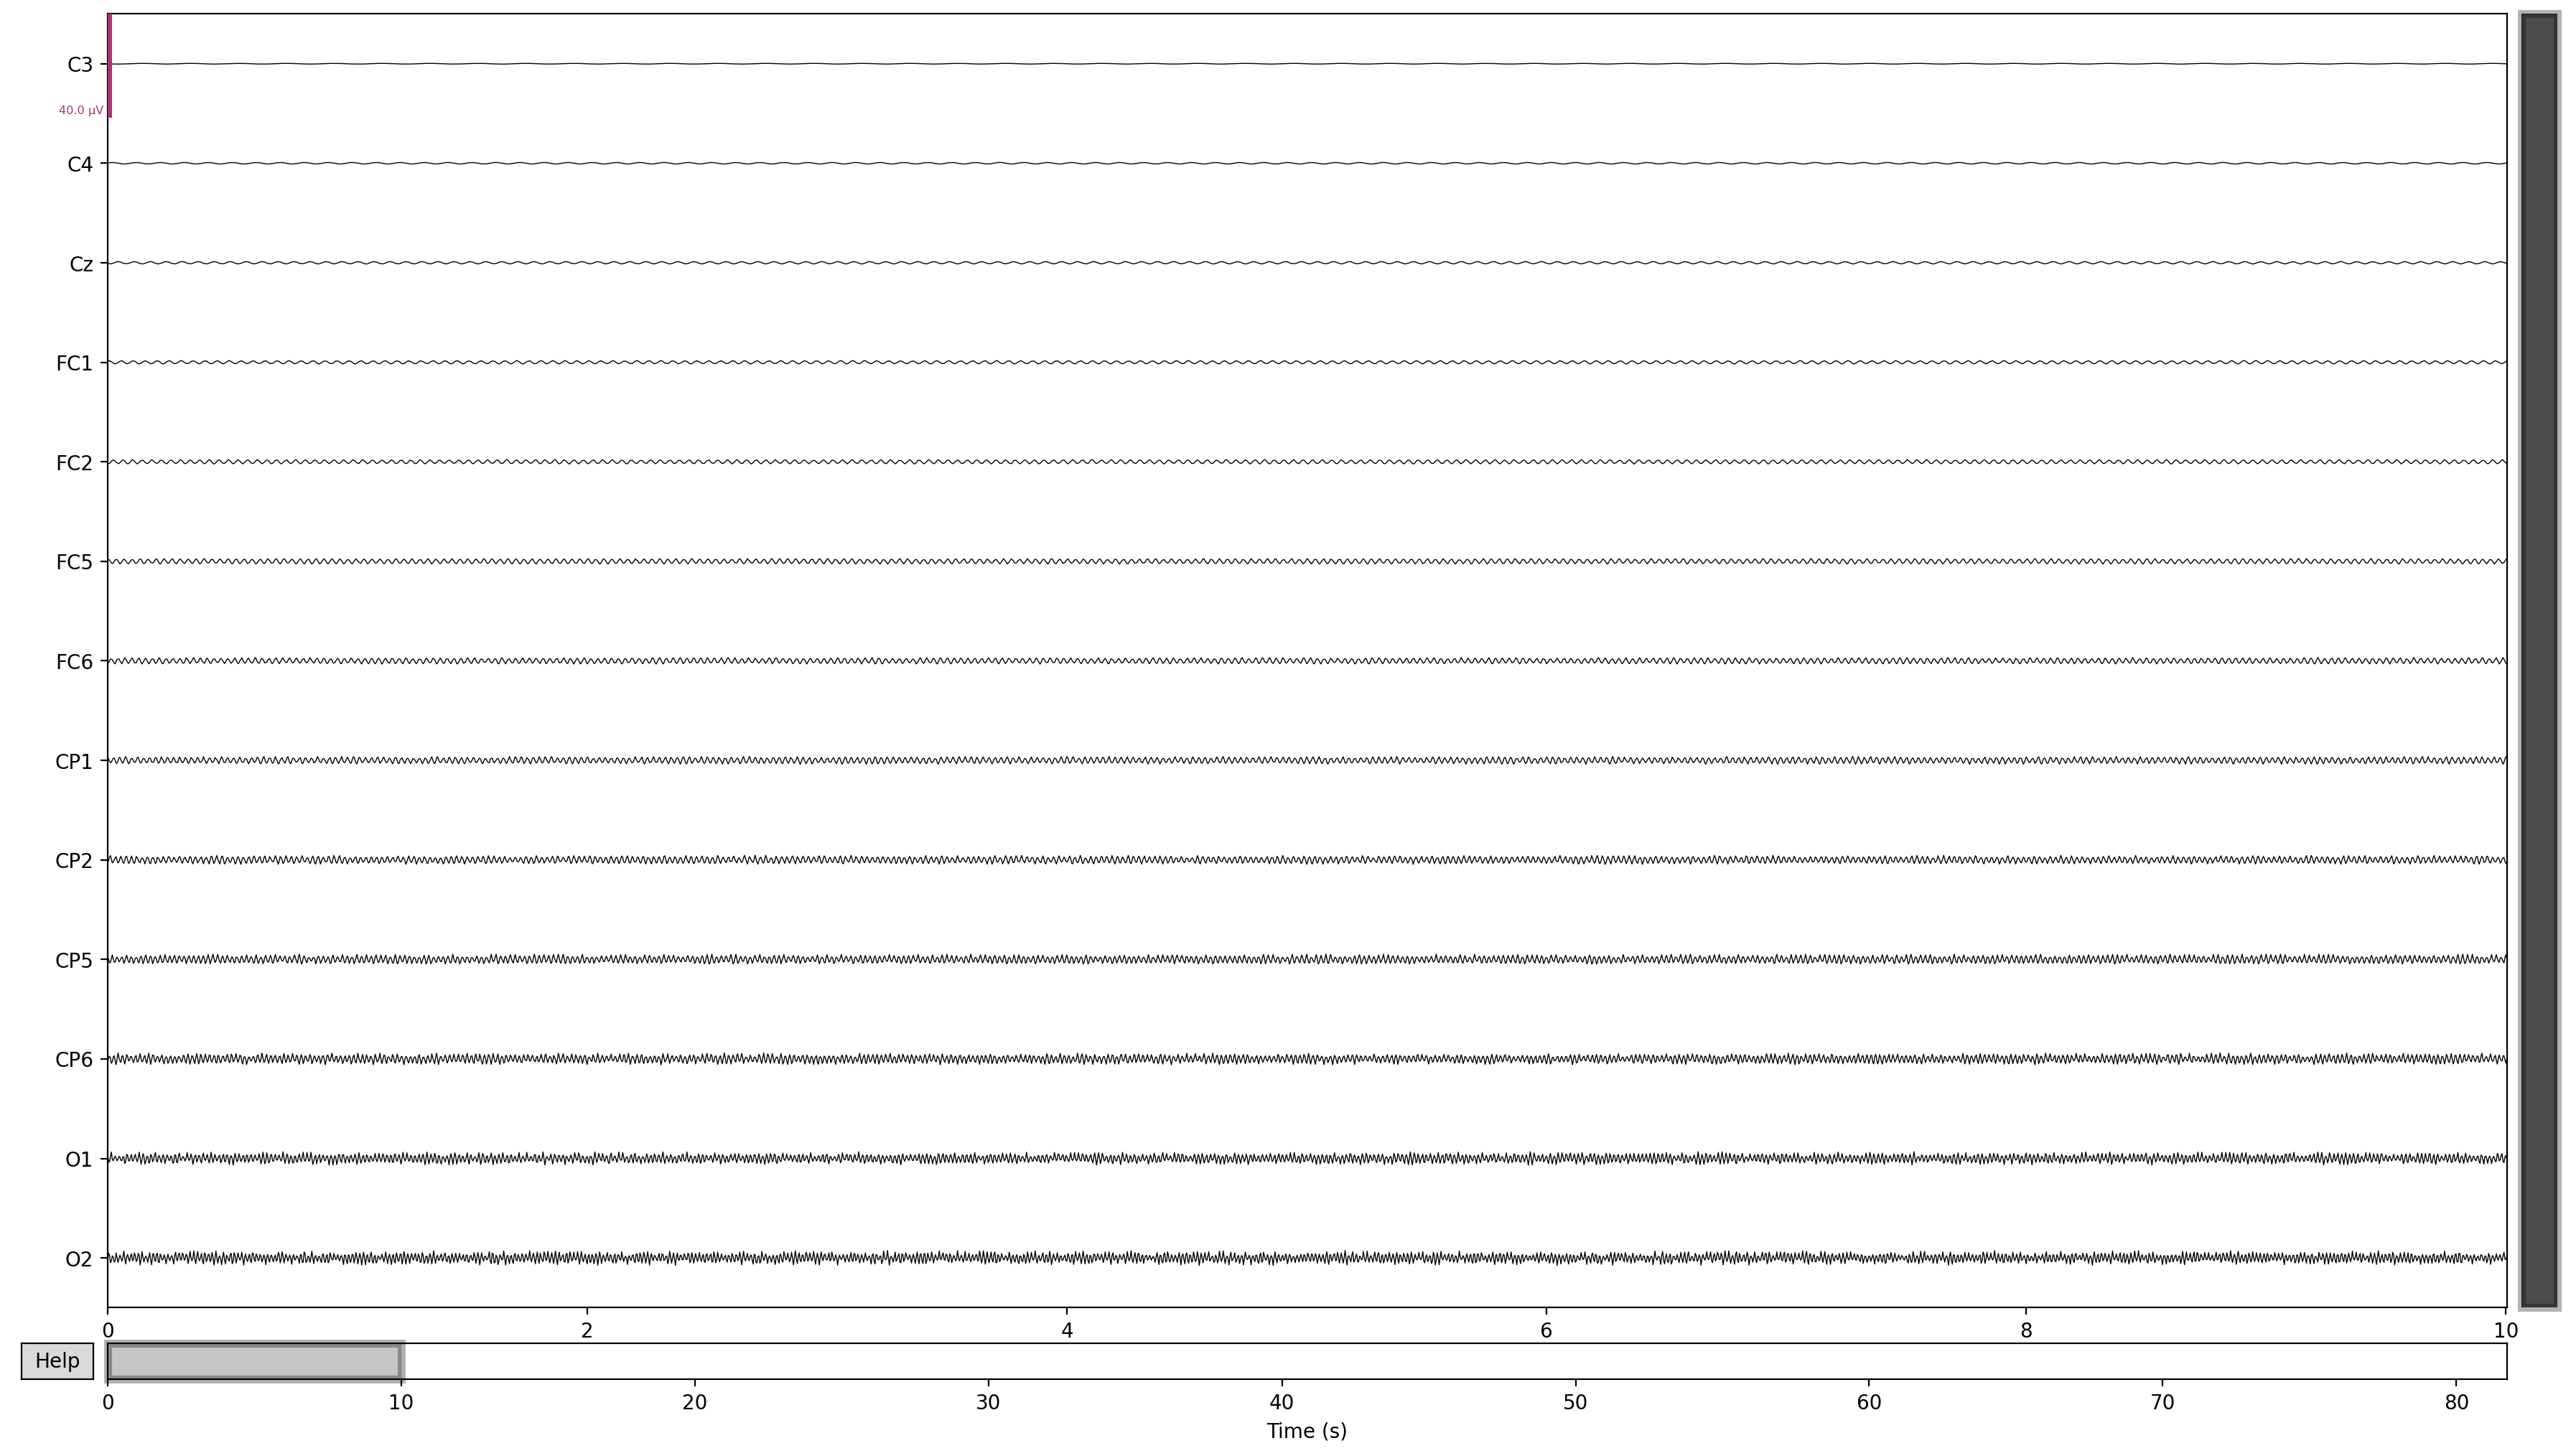

In [5]:
raw = mne.io.RawArray(eeg_data, info)
#raw_filter = raw.filter(l_freq = 0.5, h_freq = 60)
raw.plot()
#raw_filter.plot(scalings=dict(eeg=100e-6), duration=1, start=14)

In [6]:
# lets aling the time of event to the recording onset by seconds
start_time = eeg_stream['time_stamps'][0]
marker_stream['time_stamps'] -= start_time

events_num = len(marker_stream['time_series'])
zeros = np.zeros(len(marker_stream['time_series'])).reshape(events_num,1)
# need to solve the string thing
events = np.concatenate((marker_stream['time_stamps'].reshape(events_num,1),zeros,np.array(marker_stream['time_series']).reshape(events_num,1)),axis = 1)
print (events)

[['6.51800825985265' '0.0' 'Standard Trial']
 ['8.521633754804498' '0.0' 'Standard Trial']
 ['10.525363049760927' '0.0' 'Standard Trial']
 ['12.529046844691038' '0.0' 'Standard Trial']
 ['14.536274539626902' '0.0' 'Standard Trial']
 ['16.54169593457482' '0.0' 'Standard Trial']
 ['18.545736929489067' '0.0' 'Standard Trial']
 ['20.551549824449467' '0.0' 'Target Trial']
 ['22.55719281936763' '0.0' 'Standard Trial']
 ['24.562526214314857' '0.0' 'Standard Trial']
 ['26.57082040925161' '0.0' 'Standard Trial']
 ['28.57350780419074' '0.0' 'Standard Trial']
 ['31.734271596214967' '0.0' 'Standard Trial']
 ['33.73944589114399' '0.0' 'Standard Trial']
 ['35.74513568606926' '0.0' 'Standard Trial']
 ['37.747663681017' '0.0' 'Standard Trial']
 ['39.75053637594101' '0.0' 'Standard Trial']
 ['41.75364877091488' '0.0' 'Standard Trial']
 ['43.75710136585985' '0.0' 'Target Trial']
 ['45.76161676077754' '0.0' 'Standard Trial']
 ['47.766412855737144' '0.0' 'Standard Trial']
 ['49.77376665067277' '0.0' 'Stan

In [7]:
# make sure no strings in marker
events[:,2] = np.char.replace(events[:,2], 'Standard Trial', '20')
events[:,2] = np.char.replace(events[:,2], 'Target Trial', '21')
# delete last row as it contains empty string
events = np.delete(events, -1, 0)

In [8]:
events = events.astype(float)
events[:,0] *= 125 # time to time stamp

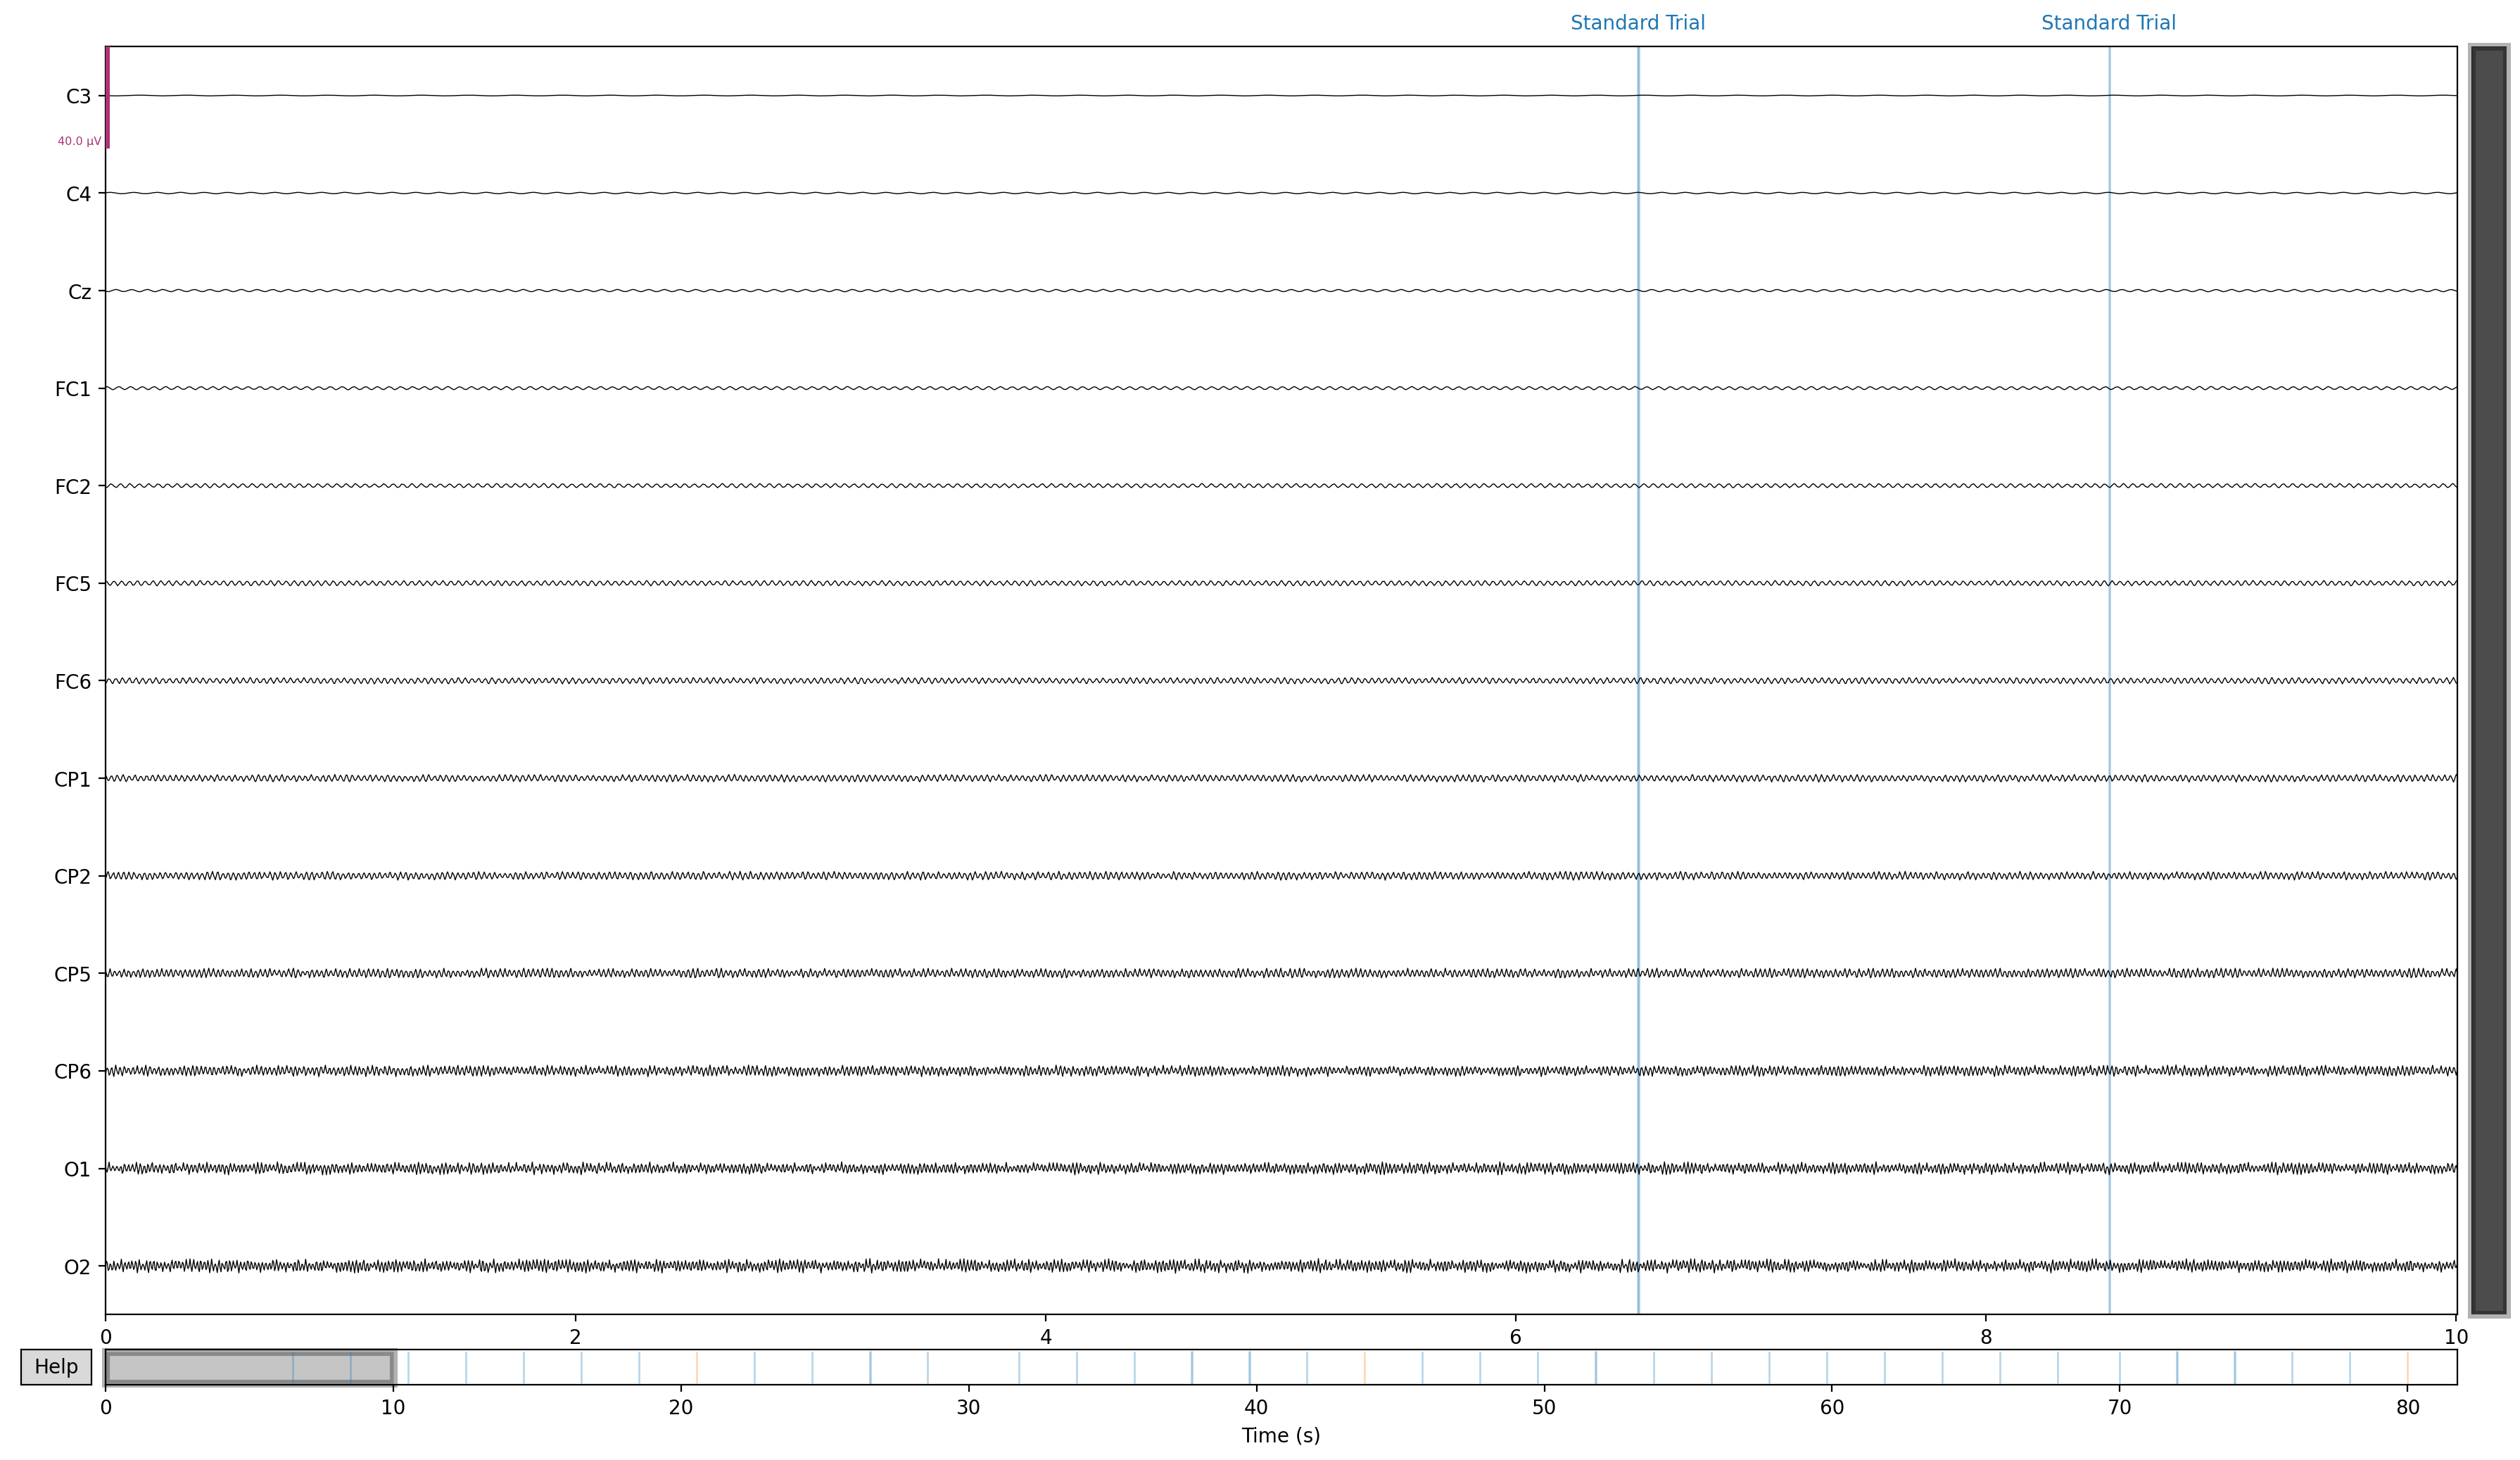

In [9]:
mapping = {20: 'Standard Trial', 21: 'Target Trial'}
# PAY ATTENTION. sfreq=raw.info['sfreq'] is not good. since raw.info['sfreq'] is 250 and not 125
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=125,
    orig_time=None)
raw.set_annotations(annot_from_events)
raw.plot()

## Preproccesing

### Mark bad channels and drop them

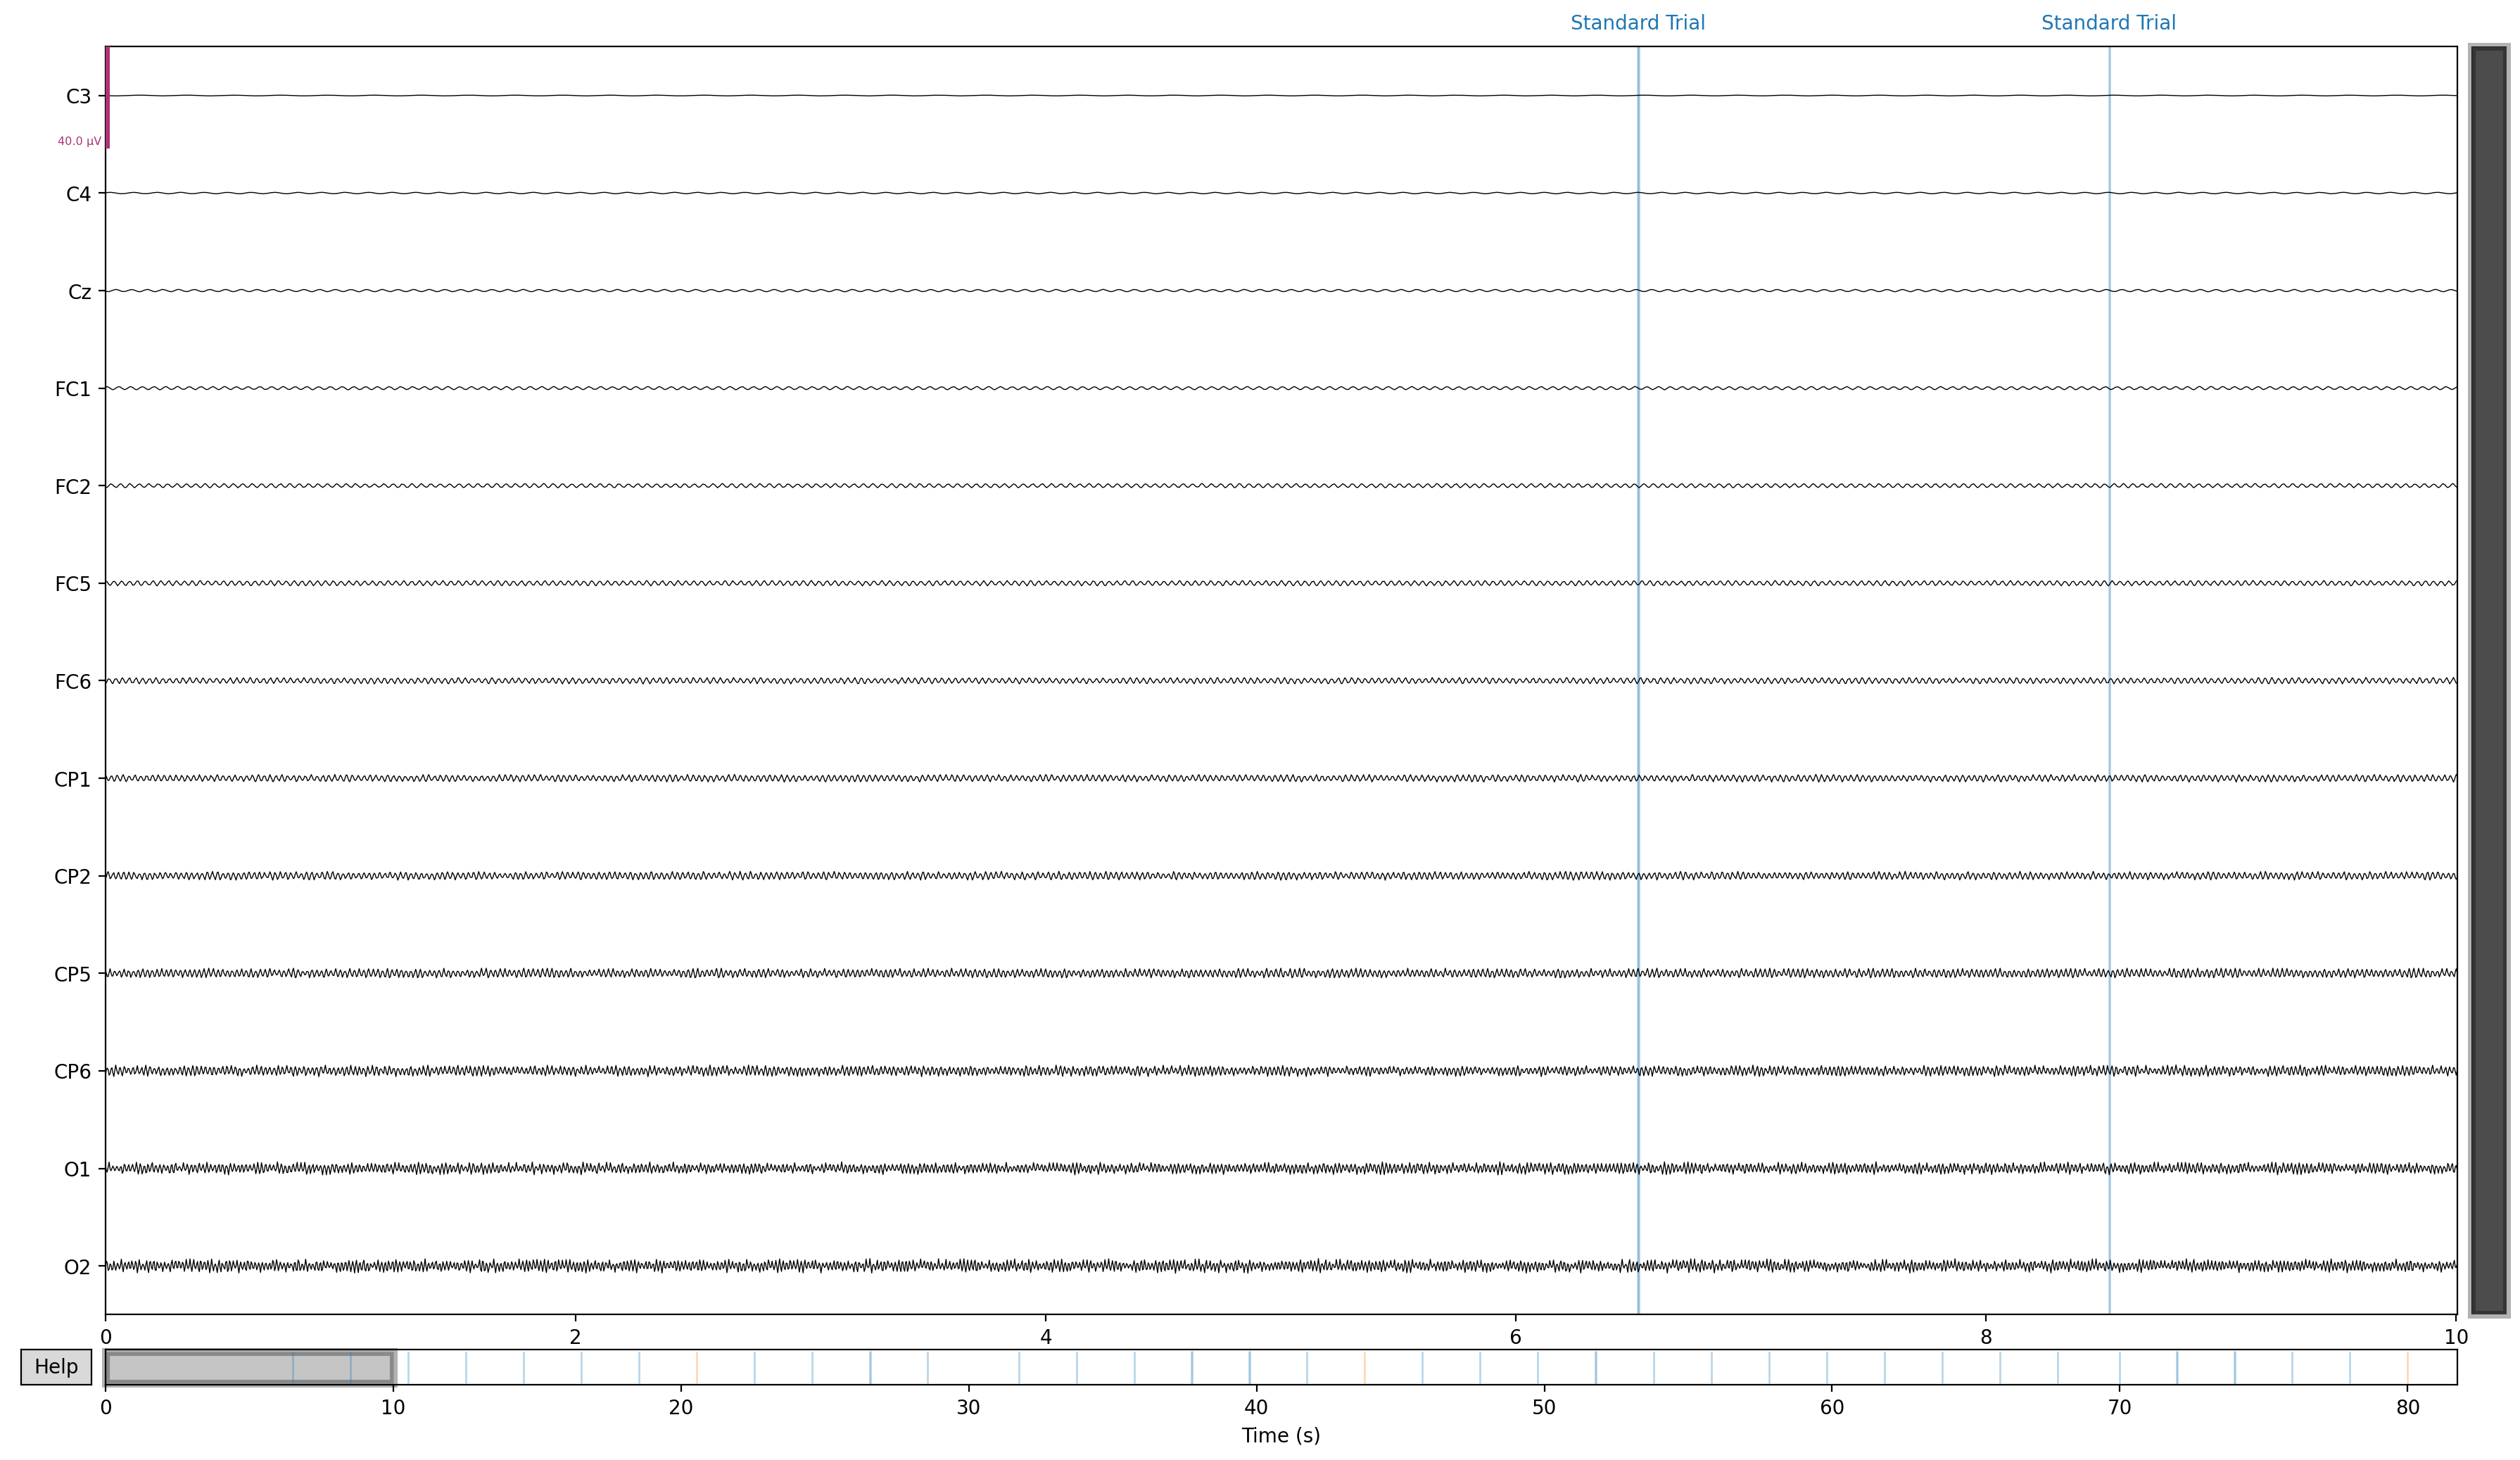

In [10]:
raw.plot()

In [11]:
raw.drop_channels(raw.info['bads'])

<RawArray | 13 x 20430 (81.7 s), ~2.0 MB, data loaded>

## Epoching

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events_from_annot, tmin=-0.2, tmax=1, event_id=event_dict,detrend=0,baseline= (-0.2,0))



In [13]:
## Plot evoked data

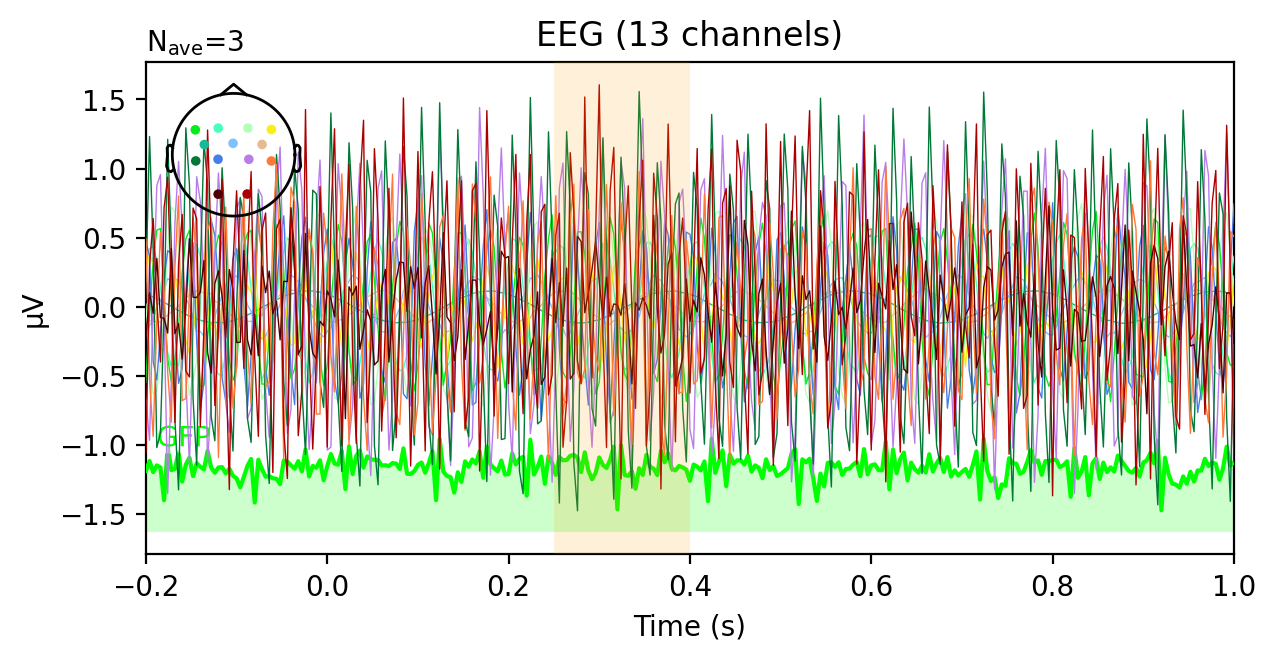

In [53]:
P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal

odd_evoked =  epochs['Target Trial'].average()
odd_evoked.plot(gfp=True,
    highlight=P300_window)



stand_evoked =  epochs['Target Trial'].average()
stand_evoked.plot(gfp=True,
    highlight=P300_window)

In [55]:
#stan_evoked = epochs['Standard Trial'].average()
#odd_evoked = epochs['Target Trial'].average()

mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked), picks= ['CP2','CP1'],combine='mean' )

combining channels using "mean"
combining channels using "mean"


[<Figure size 1600x1200 with 1 Axes>]

In [49]:

epochs.plot_image(picks='eeg', combine='mean')
epochs['Target Trial'].plot_image(picks='eeg', combine='mean')

Using data from preloaded Raw for 37 events and 301 original time points ...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
Using data from preloaded Raw for 3 events and 301 original time points ...
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


[<Figure size 1280x960 with 3 Axes>]

We can also plot sensor locations:

In [ ]:
raw.plot_sensors(show_names= True)

In **3d** its even cooler:

In [ ]:
raw.plot_sensors(show_names= True,kind= '3d')

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
